# Data Re-Uploading on a multi circle data set, with squeezing, RxRzRx circuit order

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np


from scipy.sparse.linalg import expm
from scipy.sparse import coo_matrix, csc_matrix, diags, identity


import jax.numpy as jnp
from jax import grad, vmap, jit
from jax import random

import jax

import scipy

from tqdm import tqdm

from sklearn.utils import shuffle

import qutip as q

from tqdm import tqdm

#from bloch_3d_plot import plot_bloch



from sklearn.model_selection import train_test_split



We again first define the spin matrices and the functions that act on a state.

In [4]:
l = 1 # spin length

# let's put together spin matrices
dim_qudit = 2*l+1
qudit_range = np.arange(l, -(l+1),-1)

Id  =  scipy.sparse.csc_matrix(identity(dim_qudit))
Lx  =  scipy.sparse.csc_matrix(1/2*diags([np.sqrt([(l-m+1)*(l+m) for m in qudit_range[:-1]]), np.sqrt([(l+m+1)*(l-m) for m in qudit_range[1:]]) ], [-1, 1]))
Lz  =  scipy.sparse.csc_matrix(diags([qudit_range], [0]))
Lz2 = Lz.multiply(Lz)
Lx2 = Lx.multiply(Lx)

Lx = Lx.toarray()
Lz = Lz.toarray()
Lz2 = Lz2.toarray()


Lx = jnp.array(Lx)
Lz = jnp.array(Lz)
Lz2 = jnp.array(Lz2)

In [5]:
def Rx(psi, theta, conj=False):
    if conj:
        Ux = jax.scipy.linalg.expm(1j*theta*Lx)
    else:
        Ux = jax.scipy.linalg.expm(-1j*theta*Lx)
    psi = jnp.dot(Ux,psi)
    return psi

def Rz(psi, theta, conj=False):
    if conj:
        Uz = jax.scipy.linalg.expm(1j*theta*Lz)
    else:
        Uz = jax.scipy.linalg.expm(-1j*theta*Lz)
    psi = jnp.dot(Uz,psi)
    return psi

def Rz2(psi, theta, conj=False):
    if conj:
        Uz2 = jax.scipy.linalg.expm(1j*theta*Lz2)
    else:
        Uz2 = jax.scipy.linalg.expm(-1j*theta*Lz2)
    psi = jnp.dot(Uz2,psi)
    return psi

def Initialization(psi :np.array, x1: float, x2: float, conj=False)-> np.array:
    psi = Rz(psi, x1)
    return Rx(psi, x2)



In [6]:
state_labels = [[0], [int((2*l+1)//2)], [-1]]

def cost_circ(params, x, y):

    
    loss = 1-circ(params, x, y)**2
    return loss 


def circ(params, x, y):

    psi = 1j*jnp.zeros(int(l*2+1))
    #This is necessary since jnp arrays are immutable
    psi = jax.ops.index_add(psi, 0, 1+1j*0)
    
    label = 1j*jnp.zeros(int(l*2+1))
    #This is necessary since jnp arrays are immutable
    label = jax.ops.index_add(label, y, 1+1j*0)
    for i in range(0, len(params)-1):
    
        psi = Initialization(psi, x[0], x[1])
    
        psi = Rx(psi, params[i][0])
        psi = Rz(psi, params[i][1])
        psi = Rx(psi, params[i][2])
        psi = Rz2(psi, params[i][3])
    
    psi = Rx(psi, params[i+1][0])
    psi = Rz(psi, params[i+1][1])
    psi = Rx(psi, params[i+1][2])

    
    return jnp.abs(jnp.dot(psi, label))


def test(params, x, state_labels=state_labels):

    fidelity_values = []
    dm_labels = state_labels
    predicted = []

    
    fidelities = jnp.array([circ(params, x, dm) for dm in dm_labels])
    best_fidel = jnp.argmax(fidelities)
    #print(fidelities, best_fidel)
    

    return best_fidel

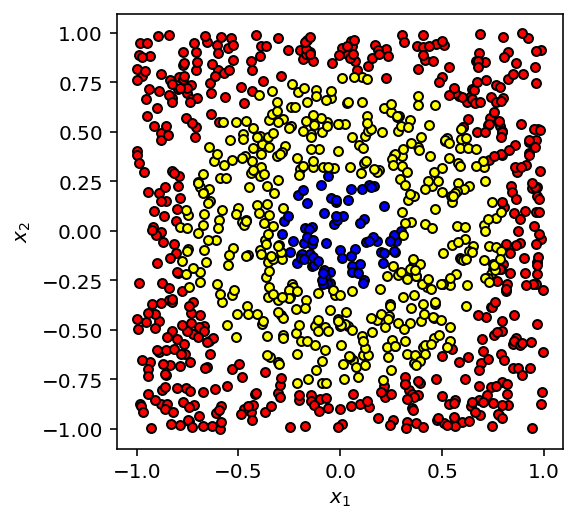

In [7]:
def accuracy_score(y_true, y_pred):

    score = y_true == y_pred
    return score.sum() / len(y_true)


def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):

    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x) < radius and np.linalg.norm(x) >= 0.3:
            y =  (2*l+1)//2
        elif np.linalg.norm(x) < radius:
            y = -1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)




def plot_data(x, y, fig=None, ax=None, title=None):

    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == -1
    yellows = y == int((2*l+1)//2)
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.scatter(x[yellows, 0], x[yellows, 1], c="yellow", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(title)


Xdata, ydata = circle(1000)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)

def iterate_minibatches(inputs, targets, batch_size):

    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

We then need the gradient of the cost function.

In [8]:
@jit
def vmap_cost(params, X_batched, y_batched):
    return vmap(cost_circ,  in_axes=(None, 0, 0))(params, X_batched, y_batched).sum()/len(X_batched)

@jit
def vmap_cost_ind(params, X_batched, y_batched, beta=0.3):
    return vmap(cost_circ,  in_axes=(None, 0, 0, None, None))(params, X_batched, y_batched, beta, True)

@jit
def vmap_test(params, X_batched, state_labels):
    return vmap(test,  in_axes=(None, 0, None))(params, X_batched, state_labels)


cost_circ_grad = grad(vmap_cost, argnums=0)

In [9]:
state_labels_flat = np.array(state_labels).flatten()

Now we have everything we need and can start learning. We first need to create the dataset and choose random parameters to start.

In [10]:
x_data, y_data = circle(1000)

batch_size = 100

num_layers = 5

num_params = 4

x_data, y_data = shuffle(x_data, y_data)


train_x, test_x, train_y, test_y = train_test_split(x_data, y_data)



--------------------------------------
Starting Learning with 2 layer(s)!
Starting Epoch 1, learning rate: 0.05
Epoch 1, Loss: 0.583, Accuracy: 0.352
Starting Epoch 2, learning rate: 0.05
Epoch 2, Loss: 0.580, Accuracy: 0.356
Starting Epoch 3, learning rate: 0.05
Epoch 3, Loss: 0.576, Accuracy: 0.376
Starting Epoch 4, learning rate: 0.05
Epoch 4, Loss: 0.568, Accuracy: 0.424
Starting Epoch 5, learning rate: 0.05
Epoch 5, Loss: 0.557, Accuracy: 0.492
Starting Epoch 6, learning rate: 0.05
Epoch 6, Loss: 0.545, Accuracy: 0.580
Starting Epoch 7, learning rate: 0.05
Epoch 7, Loss: 0.533, Accuracy: 0.516
Starting Epoch 8, learning rate: 0.05
Epoch 8, Loss: 0.525, Accuracy: 0.464
Starting Epoch 9, learning rate: 0.05
Epoch 9, Loss: 0.523, Accuracy: 0.456
Starting Epoch 10, learning rate: 0.05
Epoch 10, Loss: 0.521, Accuracy: 0.448
Starting Epoch 11, learning rate: 0.05
Epoch 11, Loss: 0.521, Accuracy: 0.448
Starting Epoch 12, learning rate: 0.05
Epoch 12, Loss: 0.520, Accuracy: 0.472
Starting

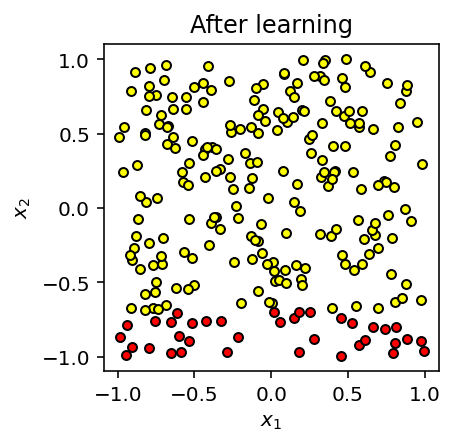

--------------------------------------
Starting Learning with 3 layer(s)!
Starting Epoch 1, learning rate: 0.05
Epoch 1, Loss: 0.487, Accuracy: 0.596
Starting Epoch 2, learning rate: 0.05
Epoch 2, Loss: 0.447, Accuracy: 0.608
Starting Epoch 3, learning rate: 0.05
Epoch 3, Loss: 0.437, Accuracy: 0.624
Starting Epoch 4, learning rate: 0.05
Epoch 4, Loss: 0.436, Accuracy: 0.624
Starting Epoch 5, learning rate: 0.05
Epoch 5, Loss: 0.428, Accuracy: 0.624
Starting Epoch 6, learning rate: 0.05
Epoch 6, Loss: 0.426, Accuracy: 0.628
Starting Epoch 7, learning rate: 0.05
Epoch 7, Loss: 0.427, Accuracy: 0.616
Starting Epoch 8, learning rate: 0.05
Epoch 8, Loss: 0.424, Accuracy: 0.624
Starting Epoch 9, learning rate: 0.05
Epoch 9, Loss: 0.427, Accuracy: 0.636
Starting Epoch 10, learning rate: 0.05
Epoch 10, Loss: 0.423, Accuracy: 0.624
Starting Epoch 11, learning rate: 0.05
Epoch 11, Loss: 0.424, Accuracy: 0.612
Starting Epoch 12, learning rate: 0.05
Epoch 12, Loss: 0.422, Accuracy: 0.616
Starting

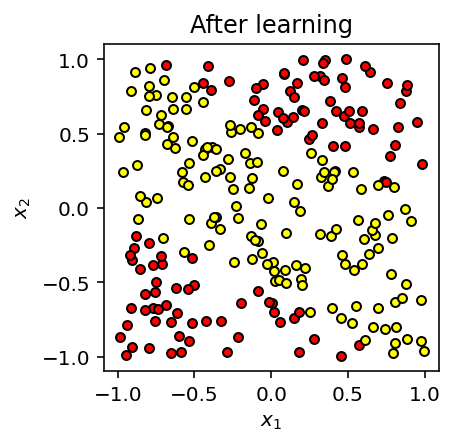

--------------------------------------
Starting Learning with 4 layer(s)!
Starting Epoch 1, learning rate: 0.05
Epoch 1, Loss: 0.529, Accuracy: 0.520
Starting Epoch 2, learning rate: 0.05
Epoch 2, Loss: 0.498, Accuracy: 0.560
Starting Epoch 3, learning rate: 0.05
Epoch 3, Loss: 0.485, Accuracy: 0.576
Starting Epoch 4, learning rate: 0.05
Epoch 4, Loss: 0.467, Accuracy: 0.580
Starting Epoch 5, learning rate: 0.05
Epoch 5, Loss: 0.450, Accuracy: 0.628
Starting Epoch 6, learning rate: 0.05
Epoch 6, Loss: 0.433, Accuracy: 0.684
Starting Epoch 7, learning rate: 0.05
Epoch 7, Loss: 0.420, Accuracy: 0.700
Starting Epoch 8, learning rate: 0.05
Epoch 8, Loss: 0.413, Accuracy: 0.712
Starting Epoch 9, learning rate: 0.05
Epoch 9, Loss: 0.408, Accuracy: 0.692
Starting Epoch 10, learning rate: 0.05
Epoch 10, Loss: 0.403, Accuracy: 0.684
Starting Epoch 11, learning rate: 0.05
Epoch 11, Loss: 0.398, Accuracy: 0.688
Starting Epoch 12, learning rate: 0.05
Epoch 12, Loss: 0.393, Accuracy: 0.676
Starting

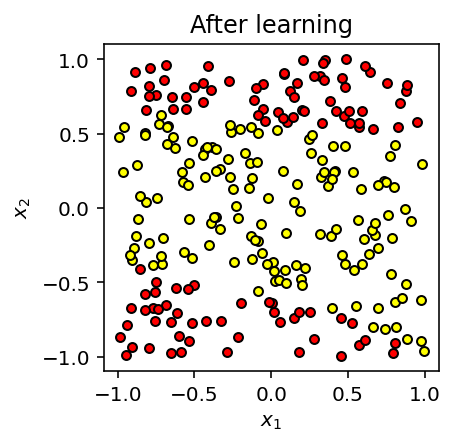

--------------------------------------
Starting Learning with 5 layer(s)!
Starting Epoch 1, learning rate: 0.05
Epoch 1, Loss: 0.522, Accuracy: 0.564
Starting Epoch 2, learning rate: 0.05
Epoch 2, Loss: 0.487, Accuracy: 0.672
Starting Epoch 3, learning rate: 0.05
Epoch 3, Loss: 0.456, Accuracy: 0.684
Starting Epoch 4, learning rate: 0.05
Epoch 4, Loss: 0.448, Accuracy: 0.656
Starting Epoch 5, learning rate: 0.05
Epoch 5, Loss: 0.434, Accuracy: 0.676
Starting Epoch 6, learning rate: 0.05
Epoch 6, Loss: 0.417, Accuracy: 0.704
Starting Epoch 7, learning rate: 0.05
Epoch 7, Loss: 0.398, Accuracy: 0.796
Starting Epoch 8, learning rate: 0.05
Epoch 8, Loss: 0.383, Accuracy: 0.816
Starting Epoch 9, learning rate: 0.05
Epoch 9, Loss: 0.372, Accuracy: 0.812
Starting Epoch 10, learning rate: 0.05
Epoch 10, Loss: 0.363, Accuracy: 0.800
Starting Epoch 11, learning rate: 0.05
Epoch 11, Loss: 0.359, Accuracy: 0.804
Starting Epoch 12, learning rate: 0.05
Epoch 12, Loss: 0.355, Accuracy: 0.808
Starting

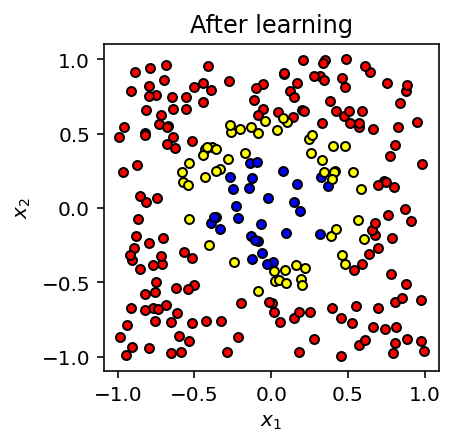

--------------------------------------
Starting Learning with 6 layer(s)!
Starting Epoch 1, learning rate: 0.05
Epoch 1, Loss: 0.535, Accuracy: 0.544
Starting Epoch 2, learning rate: 0.05
Epoch 2, Loss: 0.485, Accuracy: 0.540
Starting Epoch 3, learning rate: 0.05
Epoch 3, Loss: 0.453, Accuracy: 0.576
Starting Epoch 4, learning rate: 0.05
Epoch 4, Loss: 0.419, Accuracy: 0.720
Starting Epoch 5, learning rate: 0.05
Epoch 5, Loss: 0.397, Accuracy: 0.768
Starting Epoch 6, learning rate: 0.05
Epoch 6, Loss: 0.381, Accuracy: 0.804
Starting Epoch 7, learning rate: 0.05
Epoch 7, Loss: 0.375, Accuracy: 0.788
Starting Epoch 8, learning rate: 0.05
Epoch 8, Loss: 0.368, Accuracy: 0.784
Starting Epoch 9, learning rate: 0.05
Epoch 9, Loss: 0.364, Accuracy: 0.796
Starting Epoch 10, learning rate: 0.05
Epoch 10, Loss: 0.362, Accuracy: 0.780
Starting Epoch 11, learning rate: 0.05
Epoch 11, Loss: 0.362, Accuracy: 0.784
Starting Epoch 12, learning rate: 0.05
Epoch 12, Loss: 0.360, Accuracy: 0.776
Starting

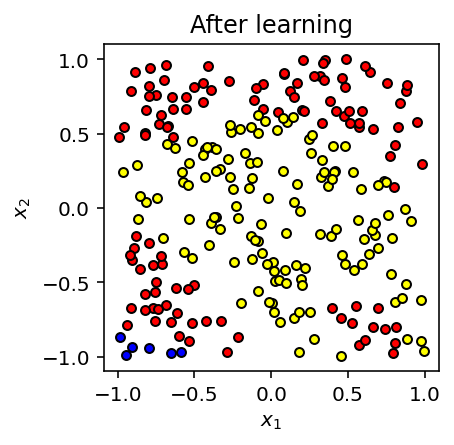

--------------------------------------
Starting Learning with 7 layer(s)!
Starting Epoch 1, learning rate: 0.05
Epoch 1, Loss: 0.627, Accuracy: 0.384
Starting Epoch 2, learning rate: 0.05
Epoch 2, Loss: 0.593, Accuracy: 0.472
Starting Epoch 3, learning rate: 0.05
Epoch 3, Loss: 0.544, Accuracy: 0.528
Starting Epoch 4, learning rate: 0.05
Epoch 4, Loss: 0.522, Accuracy: 0.548
Starting Epoch 5, learning rate: 0.05
Epoch 5, Loss: 0.493, Accuracy: 0.560
Starting Epoch 6, learning rate: 0.05
Epoch 6, Loss: 0.425, Accuracy: 0.676
Starting Epoch 7, learning rate: 0.05
Epoch 7, Loss: 0.388, Accuracy: 0.748
Starting Epoch 8, learning rate: 0.05
Epoch 8, Loss: 0.379, Accuracy: 0.728
Starting Epoch 9, learning rate: 0.05
Epoch 9, Loss: 0.369, Accuracy: 0.764
Starting Epoch 10, learning rate: 0.05
Epoch 10, Loss: 0.363, Accuracy: 0.796
Starting Epoch 11, learning rate: 0.05
Epoch 11, Loss: 0.360, Accuracy: 0.788
Starting Epoch 12, learning rate: 0.05
Epoch 12, Loss: 0.354, Accuracy: 0.808
Starting

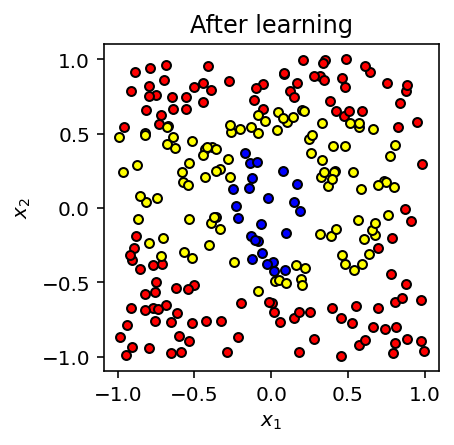

--------------------------------------
Starting Learning with 8 layer(s)!
Starting Epoch 1, learning rate: 0.05
Epoch 1, Loss: 0.588, Accuracy: 0.432
Starting Epoch 2, learning rate: 0.05
Epoch 2, Loss: 0.519, Accuracy: 0.556
Starting Epoch 3, learning rate: 0.05
Epoch 3, Loss: 0.434, Accuracy: 0.628
Starting Epoch 4, learning rate: 0.05
Epoch 4, Loss: 0.420, Accuracy: 0.652
Starting Epoch 5, learning rate: 0.05
Epoch 5, Loss: 0.406, Accuracy: 0.684
Starting Epoch 6, learning rate: 0.05
Epoch 6, Loss: 0.399, Accuracy: 0.716
Starting Epoch 7, learning rate: 0.05
Epoch 7, Loss: 0.387, Accuracy: 0.740
Starting Epoch 8, learning rate: 0.05
Epoch 8, Loss: 0.378, Accuracy: 0.776
Starting Epoch 9, learning rate: 0.05
Epoch 9, Loss: 0.370, Accuracy: 0.796
Starting Epoch 10, learning rate: 0.05
Epoch 10, Loss: 0.358, Accuracy: 0.788
Starting Epoch 11, learning rate: 0.05
Epoch 11, Loss: 0.347, Accuracy: 0.796
Starting Epoch 12, learning rate: 0.05
Epoch 12, Loss: 0.337, Accuracy: 0.800
Starting

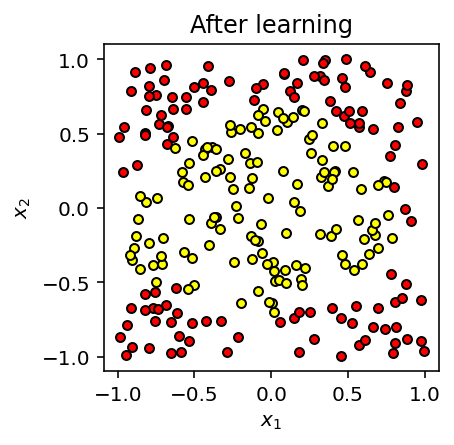

--------------------------------------
Starting Learning with 9 layer(s)!
Starting Epoch 1, learning rate: 0.05
Epoch 1, Loss: 0.515, Accuracy: 0.640
Starting Epoch 2, learning rate: 0.05
Epoch 2, Loss: 0.449, Accuracy: 0.732
Starting Epoch 3, learning rate: 0.05
Epoch 3, Loss: 0.421, Accuracy: 0.716
Starting Epoch 4, learning rate: 0.05
Epoch 4, Loss: 0.412, Accuracy: 0.720
Starting Epoch 5, learning rate: 0.05
Epoch 5, Loss: 0.401, Accuracy: 0.748
Starting Epoch 6, learning rate: 0.05
Epoch 6, Loss: 0.392, Accuracy: 0.760
Starting Epoch 7, learning rate: 0.05
Epoch 7, Loss: 0.378, Accuracy: 0.748
Starting Epoch 8, learning rate: 0.05
Epoch 8, Loss: 0.370, Accuracy: 0.740
Starting Epoch 9, learning rate: 0.05
Epoch 9, Loss: 0.365, Accuracy: 0.748
Starting Epoch 10, learning rate: 0.05
Epoch 10, Loss: 0.367, Accuracy: 0.836
Starting Epoch 11, learning rate: 0.05
Epoch 11, Loss: 0.350, Accuracy: 0.756
Starting Epoch 12, learning rate: 0.05
Epoch 12, Loss: 0.337, Accuracy: 0.768
Starting

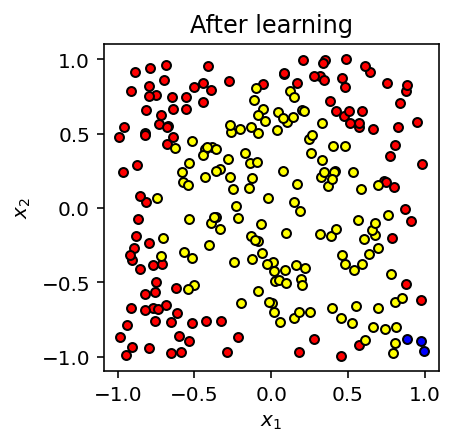

In [13]:
num_layers_list = [2, 3, 4, 5, 6, 7, 8, 9]
np.random.seed(1)

for num_layer in num_layers_list:
    print("--------------------------------------")
    print(f"Starting Learning with {num_layer} layer(s)!")
    np.random.seed(42)
    params = np.random.uniform(size=(num_layer, num_params))*np.pi/2


    pred_pre = vmap_test(params, train_x, state_labels=state_labels_flat)
    pred_pre = np.array(pred_pre)
    pred_pre = np.array(pred_pre)
    for n, prediction in enumerate(pred_pre):
        pred_pre[n] = state_labels_flat[prediction]

    

    beta=0

    losses = []
    train_acc = []
    param_list = []

    epochs = 40

    learning_rate = 0.05
    opt = AdamOptimizer(learning_rate)

    for i in range(epochs):
        #print("--------------------------------------")
        print(f"Starting Epoch {i+1}, learning rate: {learning_rate:.2f}")

        x_train, y_train = shuffle(train_x, train_y)
        for X_Batch, Y_Batch in iterate_minibatches(x_train, y_train, batch_size):
            #print(X_Batch.shape, Y_Batch.shape)
            params = opt.step(vmap_cost, params, grad_fn=cost_circ_grad, X_batched=X_Batch, y_batched=Y_Batch)
        param_list.append(params)
        pred_test = vmap_test(params, test_x, state_labels_flat)
        pred_test = np.array(pred_test)
        for n, prediction in enumerate(pred_test):
            pred_test[n] = used_labels_arr[prediction]
        acc = accuracy_score(test_y, pred_test)
        loss = vmap_cost(params, train_x, train_y)


        losses.append(loss)
        train_acc.append(acc)
        print(f"Epoch {i+1}, Loss: {loss:.3f}, Accuracy: {acc:.3f}")
        #print(params)
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    plot_data(test_x, pred_test, title="After learning", fig=fig, ax=ax)
    plt.show()
    np.save(f"Data_Circle_Squeez_Order/params_{num_layer}-layers-correct.npy", param_list)
    np.save(f"Data_Circle_Squeez_Order/loss_{num_layer}-layers-correct.npy", losses)
    np.save(f"Data_Circle_Squeez_Order/acc_{num_layer}-layers-correct.npy", train_acc)


